<a href="https://colab.research.google.com/github/raysaleide/PretaLab/blob/main/Aula_ML_Pretalab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação de imagem


In [ ]:
!wget https://img.freepik.com/fotos-gratis/jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg

--2025-05-15 23:25:16--  https://img.freepik.com/fotos-gratis/jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg
Resolving img.freepik.com (img.freepik.com)... 23.67.33.141, 23.67.33.153, 2600:1409:9800:e3::172e:e40c, ...
Connecting to img.freepik.com (img.freepik.com)|23.67.33.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79857 (78K) [image/jpeg]
Saving to: ‘jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg’

jovem-mulher-negra- 100%[===================>]  77.99K   212KB/s    in 0.4s    

2025-05-15 23:25:18 (212 KB/s) - ‘jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg’ saved [79857/79857]



In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
from PIL import Image


pipe = pipeline("image-classification", model="google/vit-base-patch32-384", device=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


In [ ]:
imagem = Image.open("jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg")
res = pipe(imagem)

res

[{'label': 'wig', 'score': 0.780887246131897},
 {'label': 'sombrero', 'score': 0.13633710145950317},
 {'label': 'cowboy hat, ten-gallon hat', 'score': 0.01060372032225132},
 {'label': 'maraca', 'score': 0.004451786633580923},
 {'label': 'bonnet, poke bonnet', 'score': 0.0033342649694532156}]

In [ ]:
# Pipeline para detecção de objetos/pessoas + contexto
detector = pipeline("object-detection", model="facebook/detr-resnet-50")
classifier = pipeline("image-classification", model="google/vit-base-patch16-224")

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cpu


In [ ]:
# Analisar imagem
imagem = "jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg"
detections = detector(imagem)  # Detecta pessoas e objetos
person_bbox = [d for d in detections if d['label'] == 'person'][0]  # Pega a pessoa principal

In [ ]:
result = classifier("jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg")  # Classifica a pessoa
print(result)

[{'label': 'wig', 'score': 0.9078598618507385}, {'label': 'mask', 'score': 0.004473676439374685}, {'label': 'sombrero', 'score': 0.00347369653172791}, {'label': 'maraca', 'score': 0.0030987095087766647}, {'label': 'hair spray', 'score': 0.0019782267045229673}]


In [ ]:
result = classifier("jovem-mulher-negra-surpresa-com-a-boca-aberta_23-2148183287.jpg")

print("\n🔍 Resultados da Classificação:")
print("=" * 40)
for item in result:
    print(f"🏷️ {item['label'].upper():<30} | 📊 {item['score']*100:.2f}%")
print("=" * 40)


🔍 Resultados da Classificação:
🏷️ WIG                            | 📊 90.79%
🏷️ MASK                           | 📊 0.45%
🏷️ SOMBRERO                       | 📊 0.35%
🏷️ MARACA                         | 📊 0.31%
🏷️ HAIR SPRAY                     | 📊 0.20%


## Vamos treinar Imagens

#Instalação

In [7]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Pasta

In [1]:
from google.colab import drive
# Monta o Google Drive para acessar os arquivos
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

path = "/content/drive/MyDrive/Projeto ML/Dataset-img"
print(os.listdir(path))

['mulher-preta', 'mulher-branca']


#Treinamento de dataset img

In [4]:
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 1. Primeiro, vamos organizar suas imagens
def organize_images(source_dir, target_dir, class_name):
    os.makedirs(os.path.join(target_dir, class_name), exist_ok=True) #Cria a pasta de destino (se não existir):

    for img_file in os.listdir(source_dir): #Percorre todos os arquivos na pasta original:
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.avif')): #Verifica arquivo de imagem
            src = os.path.join(source_dir, img_file) # Caminho original
            dst = os.path.join(target_dir, class_name, img_file) # Caminho novo
            shutil.copy(src, dst) # Copia (não move)

# Caminhos (ajuste conforme seu ambiente)
source_dir_brancas = '/content/drive/MyDrive/Projeto ML/Dataset-img/mulher-branca'
source_dir_pretas = '/content/drive/MyDrive/Projeto ML/Dataset-img/mulher-preta'
target_dir = '/content/dataset_organizado'

# Organizando as imagens
"""
source_dir_brancas

O que é?
É uma variável que armazena o caminho (path) do diretório onde estão armazenadas as imagens originais de mulheres brancas ou pretas.

os.path.join()

O que é?
É uma função do módulo os que combina partes de um caminho de forma correta para qualquer sistema operacional.

target_dir

O que é?
É a variável que armazena o caminho do diretório principal onde as imagens organizadas serão armazenadas.
"""
organize_images(source_dir_brancas, os.path.join(target_dir, 'treinamento'), 'brancas')
organize_images(source_dir_pretas, os.path.join(target_dir, 'treinamento'), 'pretas')


# 2. Agora o treinamento
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Reduzi porque tem poucas imagens(Ele vai processar imagem)
EPOCHS = 15 # Uma passagem completa por todo o conjunto de treinamento.

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza os valores dos pixels para [0,1]
    validation_split=0.2, # Reserva 20% dos dados para validação(Divisão treino/validação)
    rotation_range=20, # Rotaciona imagens aleatoriamente até 20 graus
    width_shift_range=0.2, # Desloca imagem horizontalmente (20% da largura)
    height_shift_range=0.2, # Desloca imagem verticalmente (20% da altura)
    horizontal_flip=True # Inverte imagem horizontalmente aleatoriamente (Flip horizontal)
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(target_dir, 'treinamento'), # Pasta com imagens
    target_size=IMG_SIZE,   # Redimensiona imagens
    batch_size=BATCH_SIZE,  # Número de imagens por lote
    class_mode='binary',  # Classificação binária
    subset='training' # Usa parte de treino (80%)
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(target_dir, 'treinamento'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Usa parte de validação (20%)
)

# Modelo simples
# Definição da arquitetura do modelo
model = Sequential([
    # Primeira camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2), # Redução de dimensionalidade
    Conv2D(64, (3, 3), activation='relu'),  # Segunda camada convolucional
    MaxPooling2D(2, 2),
    Flatten(), # Preparação para camadas densas(Transforma matriz em vetor)
    Dense(128, activation='relu'), # Camada densa (fully connected)
    Dense(1, activation='sigmoid') # Camada de saída (classificação binária)
])

# Configuração do processo de treinamento
model.compile(
    optimizer='adam',  # Otimizador eficiente
    loss='binary_crossentropy', # Função de perda para classificação binária
    metrics=['accuracy'] # Métrica a ser monitorada
)

# Treinamento
history = model.fit(
    train_generator, # Dados de treino
    validation_data=validation_generator, # Dados de validação
    epochs=EPOCHS # Número de épocas
)


# Salvar modelo
model.save('modelo_classificacao_racial.h5')

Found 20 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2958 - loss: 3.4468 - val_accuracy: 0.5000 - val_loss: 1.6778
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 899ms/step - accuracy: 0.5656 - loss: 1.4371 - val_accuracy: 0.5000 - val_loss: 1.1002
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5500 - loss: 1.0316 - val_accuracy: 0.5000 - val_loss: 0.6678
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5969 - loss: 0.6180 - val_accuracy: 0.5000 - val_loss: 0.8524
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6333 - loss: 0.6644 - val_accuracy: 0.5000 - val_loss: 0.6458
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 982ms/step - accuracy: 0.7000 - loss: 0.6079 - val_accuracy: 0.5000 - val_loss: 0.6756
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 894ms/step - accuracy: 0.6594 - loss: 0.6263 - val_accuracy: 0.5000 - val_loss: 0.7120
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - ac

# Extração de Features com MobileNetV2 + Classificador Binário

In [5]:
# Importa a arquitetura MobileNetV2 pré-treinada
from tensorflow.keras.applications import MobileNetV2

# Carrega o modelo base MobileNetV2 com pesos pré-treinados no ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Usa pesos treinados no ImageNet(Remove a última camada (classificação original e define o formato de entrada das imagens)
base_model.trainable = False # Os pesos não serão atualizados durante o treino

# Cria um novo modelo sequencial
model = Sequential([
    base_model,  # Extrai features das imagens
    Flatten(), # Transforma os features em vetor
    Dense(128, activation='relu'), # Adiciona capacidade de aprendizado
    Dense(1, activation='sigmoid') # Saída entre 0 e 1 (probabilidade)
])

# Testando Modelo


Testando imagem: https://www.minhavidamagnolia.com.br/wp-content/uploads/2024/07/Branca-Rubas-apresenta-o-Inspira-Mulher-Business-Club.png
Erro ao processar a imagem: cannot identify image file <_io.BytesIO object at 0x7fbf335413a0>

Testando imagem: https://paesadvogados.com.br/wp-content/uploads/2022/05/pardo.jpg


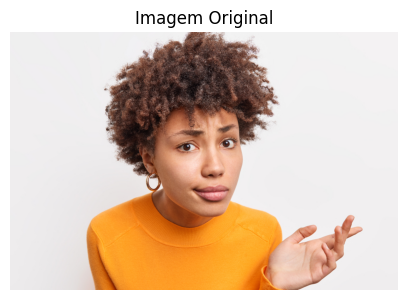

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

Resultado da Classificação:
Classe Predita: Preta
Confiança: 53.35%
Probabilidade Branca: 46.65%
Probabilidade Preta: 53.35%
Resultado: Preta (Confiança: 53.35%)


In [10]:
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Carregar o modelo treinado
model = load_model('modelo_classificacao_racial.h5')

# Função para processar imagem da internet
def test_image_from_url(img_url):
    try:[10]
1s
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Carregar o modelo treinado
model = load_model('modelo_classificacao_racial.h5')


Produtos pagos do Colab - Cancelar contratos

        # Baixar a imagem
        response = requests.get(img_url) # Timeout de 10 segundos
        img = Image.open(BytesIO(response.content)) # Verifica erros HTTP

        # Converte para RGB caso seja PNG, RGBA, etc.
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Mostrar a imagem original
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagem Original')
        plt.show()

        # Pré-processamento
        img = img.resize((224, 224)) # Redimensiona para o tamanho esperado pelo modelo
        img_array = image.img_to_array(img) # Converte para array numpy
        img_array = np.expand_dims(img_array, axis=0) # Adiciona dimensão do batch
        img_array /= 255.0  # Normaliza pixels para [0,1]

        # Fazer a predição
        prediction = model.predict(img_array) # Suprime logs
        prob_branca = 1 - prediction[0][0] # Probabilidade da classe 'preta'
        prob_preta = prediction[0][0] # Probabilidade complementar

        # Determinar a classe
        if prob_branca > prob_preta:
            classe = "Branca"
            confidence = prob_branca
        else:
            classe = "Preta"
            confidence = prob_preta

        # Mostrar resultados
        print("\nResultado da Classificação:")
        print(f"Classe Predita: {classe}")
        print(f"Confiança: {confidence:.2%}")
        print(f"Probabilidade Branca: {prob_branca:.2%}")
        print(f"Probabilidade Preta: {prob_preta:.2%}")

        return {
            'class': classe,
            'confidence': float(confidence),
            'probabilities': {
                'branca': float(prob_branca),
                'preta': float(prob_preta)
            }
        }

    except Exception as e:
        print(f"Erro ao processar a imagem: {e}")
        return None

# Exemplos de URLs para testar (substitua por URLs reais)
test_urls = [
    "https://www.minhavidamagnolia.com.br/wp-content/uploads/2024/07/Branca-Rubas-apresenta-o-Inspira-Mulher-Business-Club.png",  # URL de mulher branca
    "https://paesadvogados.com.br/wp-content/uploads/2022/05/pardo.jpg",   # URL de mulher preta

]

# Testar cada URL
for url in test_urls:
    print(f"\nTestando imagem: {url}")
    result = test_image_from_url(url)
    if result:
        print(f"Resultado: {result['class']} (Confiança: {result['confidence']:.2%})")